# Exercise on neural networks (part 1)
In this exercise we will have a look at fully connected neural networks (FCNN) for a regression task and a classification task.

## Neural Networks: motivation
### NN for regression tasks
We have already seen in previous exercises how to use linear and non-linear regression for regression tasks and supervised classification. At this point the question can arise: if we are able to perform regression and classification with other algorithms, why do we need Neural Networks (NN)?

Non-linear regression can be useful in many cases where linear regression fails. But, as explained in the previous classes, to perform non-linear regression, we need to make an hypothesis on the function's form.

<img src="https://drive.google.com/uc?id=1tJblpmEEHXxVyampNU3gJlZJ1Bo3znTF" width="50%">


This information is often hard to get. When we can't make a valid hypothesis on the function's form, NN can be used as a tool to perform regression.

### NN for classification tasks
During the lectures on clustering, algorithms like k-means were shown to perform **unsupervised** classification, but another class of tasks includes **supervised** classification.
The difference between the two is very simple: in unsupervised algorithms we classify different kind of data based on the input space topology, while to perform supervised classification we need a **labeled** training dataset (that means, we already know the correct solution for the entire dataset). This dataset is used to "train" the Machine Learning algorithm, that once trained will be able to classify data also outside of the training dataset (hopefully).

<img src="https://drive.google.com/uc?id=1B7mKRexthHkbPZVUBUhmV6FUj-m52vzc" width="80%">

At this point again, we could think to perform supervised classification tasks using logistic regression. Why bothering with Neural Networks?
Classification of datasets with highly non-linear behaviour can be difficult with classic logistic regression techniques, and, in these cases, Neural Networks offer a good alternative to handle non-linearities.

<img src="https://drive.google.com/uc?id=1eNrMFltAQ1U7qXbHyL094WLjx4-x0w1h" width="80%">


## What's an FCNN?
A fully-connected neural network is a type of artificial neural network where every neuron in one layer is connected to every neuron in the next layer.

The basic structure of a fully-connected neural network is comprised of three types of layers: **input layer, hidden layer(s), and output layer**. The input layer takes in the input data, which could be anything from an image to a sound wave to a text document. The output layer produces the final output, which could be a classification label, a predicted value, or something else, depending on the problem being solved. The hidden layer(s) are layers between the input and output layers, where the actual computation happens. These layers consist of neurons that process the input data and pass it forward through the network.

Each neuron in a fully-connected neural network receives input from all the neurons in the previous layer, applies some kind of activation function to that input, and produces an output. The output of each neuron is then sent to every neuron in the next layer, and the process is repeated until the output layer is reached.

The number of neurons in the input layer is determined by the size of the input data, while the number of neurons in the output layer is determined by the desired output of the network. The number of neurons in the hidden layers is usually chosen based on experimentation and the complexity of the problem being solved.

<img src="https://drive.usercontent.google.com/download?id=1H6dht4wtOejJgYJtPhhBjVK8QfxPW6Ov&authuser=0" width=80%">

## Software

We use pyTorch to build the NNs in this exercise. pyTorch is quite easy to use and it has support for GPU acceleration. Another popular library is tensorFlow.

## Resources

* A really good series of videos from [3Brown1Blue](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)
* Pytorch [documentation](https://pytorch.org/docs/stable/index.html) and [tutorials](https://pytorch.org/tutorials/beginner/basics/intro.html)
* Neural Network intuition: https://playground.tensorflow.org
* The second dataset contains labeled [images](https://www.cs.toronto.edu/~kriz/cifar.html). The goal is to classify the images based on the label.

# Ex 01: Regression task using Neural Networks

As in the previous case with non-linear regression, we want to find a function to approximate this noisy dataset built from the function:<br>
$f(x) = sin(x) + sin(1.5 * x) + sin(2 * x)$

Let's define the function to create our dataset:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

# function to regress:
def non_linear_func_orig(x):
    y = np.sin(x) + np.sin(1.5*x) + np.sin(2*x)
    return y

def non_linear_func(x):
    y = np.sin(x) + np.sin(1.5*x) + np.sin(2*x) + 0.15*np.random.randn(*x.shape)
    return y


We can use this code to create our dataset:

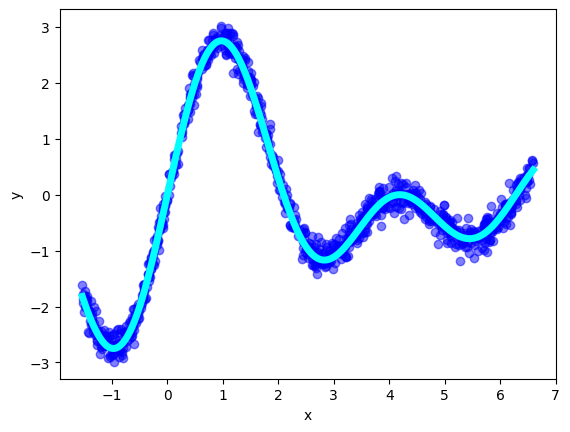

In [2]:
# This code is used to create our synthetic dataset
n_samples = 1000
seed = 42
np.random.seed(seed)

X = np.random.rand(n_samples,1) * 2.6*np.pi - np.pi/2
Y = non_linear_func(X)

x_orig = np.linspace(X.min(), X.max(), 200).reshape(200,1)
y_orig = non_linear_func_orig(x_orig)

# We can plot the dataset and the original non-linear function
plt.scatter(X.T, Y.T, c='b', alpha=0.5, label='Data')
plt.plot(x_orig, y_orig, c='cyan', lw=5, label='Original Function')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Building the Fully-Connected Neural Network

To build the architecture of the Neural Network, the first thing to do is understanding the function that is being studied.
In this case, the function we want to model with a FCNN is a function with one dependent variable and an independent one:

$y = f(x), \quad f: \mathbb{R}^1 \rightarrow \mathbb{R}^1$

This means that our Network needs to have one neuron in the input layer and one in the output layer.


Starting with a simple architecture, we can assign to the network two hidden layers, each one with a number of neurons that we define as a hyperparameter n_neurons.

<img src="https://drive.google.com/uc?id=1EBh4oFLgrREqznE_troVc9RRTGNCJRsC" width="80%">




In pytorch, the architecture of the neural network can be defined as a subclass of the nn.Module class (see pytorch [Documentation](https://pytorch.org/docs/stable/nn.html#module-torch.nn.modules.module)).

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture
class MyNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(MyNeuralNetwork, self).__init__()
        self.layers = nn.ModuleList() # initialize the layers list as an empty list using nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size)) # Add the first input layer. The layer takes as input <input_size> neurons and gets as output <hidden_size> neurons
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size)) # Add hidden layers
        self.layers.append(nn.Linear(hidden_size, output_size)) # add output layer

    def forward(self, x):    # Function to perform forward propagation
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
        x = self.layers[-1](x)
        x = torch.tanh(x)
        return x

## Forward Propagation
Now we try to perform forward propagation. The prediction will probably be very bad since we initialized random weights without training the network.

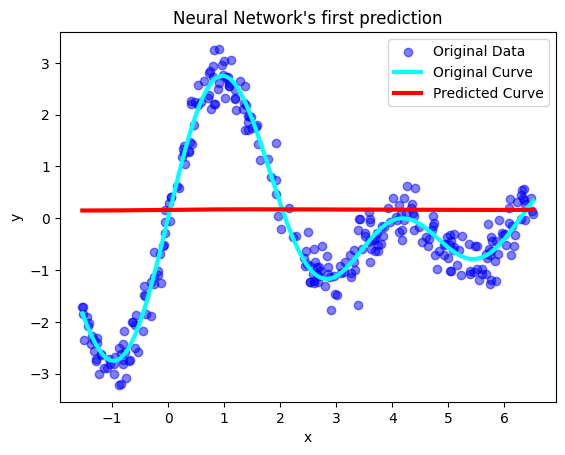

In [15]:
input_size = 1
num_layers = 5 # was 3
hidden_size = 10
output_size = 1

# For reproducibility
torch.manual_seed(42)

model = MyNeuralNetwork(input_size, hidden_size, output_size, num_layers)

with torch.no_grad():
    Y_first_pred = model(torch.tensor(x_orig, dtype=torch.float32))

plt.scatter(X, Y, c='b', alpha=0.5, label='Original Data')
plt.plot(x_orig, y_orig, c='cyan', lw=3, label='Original Curve')
plt.plot(x_orig, Y_first_pred.numpy(), c='red', lw=3, label='Predicted Curve')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Neural Network's first prediction")
plt.show()

## Split the data in training and test

Here we are splitting the data into training and test data, and also converting them to tensor objects, so that they can be used by the functions in pytorch.


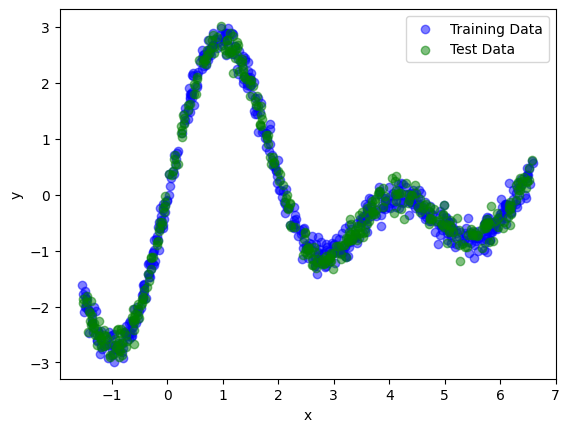

In [5]:
from sklearn.model_selection import train_test_split
# Split the training data into a new training set and a validation set
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.4, random_state=42)

# Convert the variables to tensors so that they can be used in pytorch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Rescale the input and output data between -1 and 1
# This will ease the training as all the weights of the NN will stay around 0

X_train_min = X_train.min()
X_train_max = X_train.max()

X_train_scaled = 2*(X_train-X_train_min)/(X_train_max-X_train_min) - 1
X_test_scaled = 2*(X_test-X_train_min)/(X_train_max-X_train_min) - 1

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

Y_train_min = Y_train.min()
Y_train_max = Y_train.max()

Y_train_scaled = 2*(Y_train-Y_train_min)/(Y_train_max-Y_train_min) - 1
Y_test_scaled = 2*(Y_test-Y_train_min)/(Y_train_max-Y_train_min) - 1

plt.scatter(X_train, Y_train, c='b', alpha=0.5, label='Training Data')
plt.scatter(X_test, Y_test, c='g', alpha=0.5, label='Test Data')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Loss function design
To optimize the weights, a criteria is necessary. In the simplest case, the goal is to obtain the weights that minimize the error between the prediction of the FCNN and the correct value that we use as a comparison in the test phase.

So the first thing to think about is: how do we define the error?

In the following we are going to implement the MSE (Mean Squared Error) definition of the cost function (also called loss function):

$C = \frac{1}{N} \sum_{i=1}^{N} (Y_i - \hat{Y}_i)^2$

The cost function can assume more complex shapes, with additional hyperparameters, as we will see later in this exercise.




How does the cost function affect the Neural Network?


The cost function defines how "good" the output of the NN is. What we want to do is correct the neural network output so that it reduces the error, that is an optimization problem. The optimization aims to ***find the optimal Weights that minimize the cost function***. As many optimization algorithms for non-linear functions are based on gradient descent, it's necessary to compute the gradients.

In [17]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters()) # here we are using the Adam optimizer, to optimize model.parameters, but what is there inside this attribute?

print("Weights and biases:")
for name, param in model.named_parameters():
    print(name, param.size())

Weights and biases:
layers.0.weight torch.Size([10, 1])
layers.0.bias torch.Size([10])
layers.1.weight torch.Size([10, 10])
layers.1.bias torch.Size([10])
layers.2.weight torch.Size([10, 10])
layers.2.bias torch.Size([10])
layers.3.weight torch.Size([10, 10])
layers.3.bias torch.Size([10])
layers.4.weight torch.Size([10, 10])
layers.4.bias torch.Size([10])
layers.5.weight torch.Size([1, 10])
layers.5.bias torch.Size([1])


## Backpropagation
Backpropagation is the algorithm used to "train" the neural networks, which means solving the problem of ***computing the derivatives of the cost function with respect to each network weight***.

<img src="https://drive.google.com/uc?id=1P3KeBaeCXwx9oFMl0wf5ph63INLPOBYF" width="60%">

The computation at step 3 is fundamental in order to use gradient descent to solve the optimization problem.

In the previous lines of code, we have already set up the first two steps, so let's see how to implement backpropagation.





### Computation of the derivatives
In order to perform gradient descent on the weights, we want to obtain the derivatives and update the weights such that

$\mathbf{A}^{(l)}_{k+1} = \mathbf{A}^{(l)}_{k} + \alpha ∇C$

Where $\alpha$ is the learning rate, and

$\nabla C=\frac{∂C}{∂\mathbf{A}^{(l)}}$

is the vector with all the partial derivatives of the loss with respect to **ALL** the weights. Backpropagation is the algorithm that we use to compute this term, and is based on the chain rule.

A deeper explanation regarding the computation of derivatives can be found [here]()


## Perform one optimization step
Let's try to perform one optimization step of the neural network.

In [9]:
# Steps 1 and 2 are already done, we initialized the neural network and initialized its weights to random values

# Step 3:
output = model(X_train_scaled)             # The training data X_train is run through the network to produce an output

loss = criterion(output, Y_train_scaled)  # Compute the loss

optimizer.zero_grad()               # Clears the gradients to avoid gradient accumulation
loss.backward()                     # Perform backpropagation to compute derivatives
optimizer.step()                    # Update the weights according to the gradient computation

# output2 = ...                     # Perform forward propagation again after having updated the weights
# loss2   = ...                     # Compute the loss
output2 = model(X_train_scaled)
loss2 = criterion(output2, Y_train_scaled)

print("Loss before the optimization step: {:.4f}".format(loss))
print("Loss after the optimization step:  {:.4f}".format(loss2))


Loss before the optimization step: 0.2819
Loss after the optimization step:  0.2774


## Training loop

Epoch [500/8000], Loss: 0.0195, Test loss: 0.0152
Epoch [1000/8000], Loss: 0.0176, Test loss: 0.0141
Epoch [1500/8000], Loss: 0.0105, Test loss: 0.0108
Epoch [2000/8000], Loss: 0.0100, Test loss: 0.0110
Epoch [2500/8000], Loss: 0.0097, Test loss: 0.0108
Epoch [3000/8000], Loss: 0.0092, Test loss: 0.0105
Epoch [3500/8000], Loss: 0.0088, Test loss: 0.0101
Epoch [4000/8000], Loss: 0.0082, Test loss: 0.0093
Epoch [4500/8000], Loss: 0.0080, Test loss: 0.0091
Epoch [5000/8000], Loss: 0.0079, Test loss: 0.0090
Epoch [5500/8000], Loss: 0.0079, Test loss: 0.0090
Epoch [6000/8000], Loss: 0.0079, Test loss: 0.0090
Epoch [6500/8000], Loss: 0.0079, Test loss: 0.0090
Epoch [7000/8000], Loss: 0.0079, Test loss: 0.0091
Epoch [7500/8000], Loss: 0.0078, Test loss: 0.0091
Epoch [8000/8000], Loss: 0.0079, Test loss: 0.0092


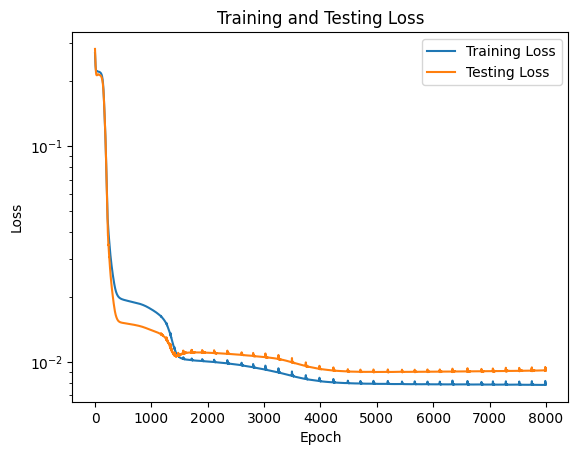

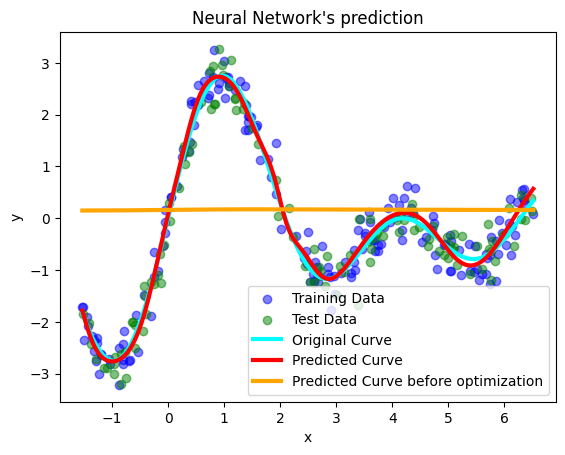

In [18]:
# Lists to store training loss and testing loss
train_loss_list = []
test_loss_list = []

# Training loop
num_epochs = 8000 #5000
for epoch in range(num_epochs):
    # Forward pass on training data
    # output = ...
    output = model(X_train_scaled)

    # compute loss on training data
    # loss = ...
    loss = criterion(output, Y_train_scaled)

    # Compute loss on testing data. NOTE: we aren't gonna use the test loss for optimization!!!
    # output_test = ...
    output_test = model(X_test_scaled)
    # loss_test   = ...
    loss_test = criterion(output_test, Y_test_scaled)

    # Backprop and optimize
    # ...                       # Clear the gradients
    # ...                       # Perform backpropagation
    # ...                       # Update the weights
    optimizer.zero_grad()   # Clear the gradients (reset gradients to zero)
    loss.backward()         # Perform backpropagation (compute gradients)
    optimizer.step()        # Update the weights (adjust parameters based on gradients)

    train_loss_list.append(loss.item()) # Save the losses
    test_loss_list.append(loss_test.item())

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test loss: {loss_test.item():.4f}')

# Plot training and testing loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(test_loss_list, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.yscale('log')
plt.legend()
plt.show()

# Plot the NN performance:
with torch.no_grad():
    # Scale all the input data to the range -1 to 1
    X_orig_torch = torch.tensor(x_orig, dtype=torch.float32)
    X_orig_scaled = 2 * (X_orig_torch - X_train_min)/(X_train_max - X_train_min) - 1

    Y_pred = model(X_orig_scaled)
    # Rescale the prediction back to the original scales
    Y_pred_rescaled = (Y_train_max-Y_train_min)/2*(Y_pred + 1) + Y_train_min

plt.scatter(X_train, Y_train, c='b', alpha=0.5, label='Training Data')
plt.scatter(X_test, Y_test, c='g', alpha=0.5, label='Test Data')
plt.plot(x_orig, y_orig, c='cyan', lw=3, label='Original Curve')
plt.plot(x_orig, Y_pred_rescaled.numpy(), c='red', lw=3, label='Predicted Curve')
plt.plot(x_orig, Y_first_pred.numpy(), c='orange', lw=3, label='Predicted Curve before optimization')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Neural Network's prediction")
plt.show()

## Recap + bonus: regularization

Weights and biases:
layers.0.weight torch.Size([10, 1])
layers.0.bias torch.Size([10])
layers.1.weight torch.Size([10, 10])
layers.1.bias torch.Size([10])
layers.2.weight torch.Size([10, 10])
layers.2.bias torch.Size([10])
layers.3.weight torch.Size([1, 10])
layers.3.bias torch.Size([1])
Epoch [500/7000], Loss: 0.0250, Test loss: 0.0213
Epoch [1000/7000], Loss: 0.0225, Test loss: 0.0200
Epoch [1500/7000], Loss: 0.0214, Test loss: 0.0194
Epoch [2000/7000], Loss: 0.0206, Test loss: 0.0189
Epoch [2500/7000], Loss: 0.0188, Test loss: 0.0175
Epoch [3000/7000], Loss: 0.0156, Test loss: 0.0165
Epoch [3500/7000], Loss: 0.0151, Test loss: 0.0162
Epoch [4000/7000], Loss: 0.0147, Test loss: 0.0159
Epoch [4500/7000], Loss: 0.0142, Test loss: 0.0154
Epoch [5000/7000], Loss: 0.0137, Test loss: 0.0148
Epoch [5500/7000], Loss: 0.0134, Test loss: 0.0145
Epoch [6000/7000], Loss: 0.0133, Test loss: 0.0143
Epoch [6500/7000], Loss: 0.0131, Test loss: 0.0141
Epoch [7000/7000], Loss: 0.0128, Test loss: 0.013

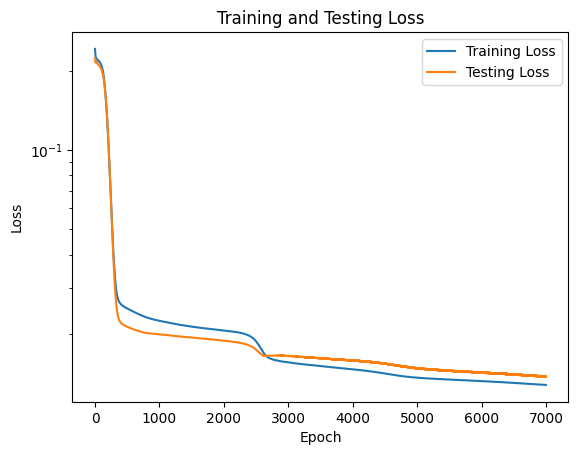

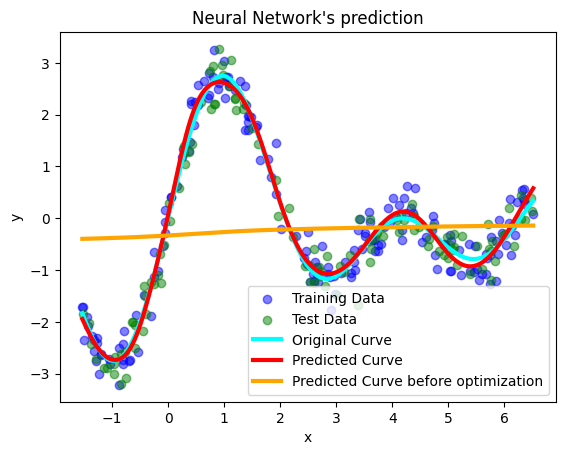

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

################################################################################
#                              Dataset generation
################################################################################
# function to regress:
def non_linear_func_orig(x):
    y = np.sin(x) + np.sin(1.5*x) + np.sin(2*x)
    return y

def non_linear_func(x):
    y = np.sin(x) + np.sin(1.5*x) + np.sin(2*x) + 0.30*np.random.randn(*x.shape)
    return y

# This code is used to create our synthetic dataset
n_samples = 300
seed = 42
np.random.seed(seed)

X = np.random.rand(n_samples,1) * 2.6*np.pi - np.pi/2
Y = non_linear_func(X)

x_orig = np.linspace(X.min(), X.max(), 200).reshape(200,1)
y_orig = non_linear_func_orig(x_orig)

# Split the training data into a new training set and a validation set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.4, random_state=42)

# Convert the variables to tensors so that they can be used in pytorch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

X_train_min = X_train.min()
X_train_max = X_train.max()

X_train_scaled = 2*(X_train-X_train_min)/(X_train_max-X_train_min) - 1
X_test_scaled = 2*(X_test-X_train_min)/(X_train_max-X_train_min) - 1

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

Y_train_min = Y_train.min()
Y_train_max = Y_train.max()

Y_train_scaled = 2*(Y_train-Y_train_min)/(Y_train_max-Y_train_min) - 1
Y_test_scaled = 2*(Y_test-Y_train_min)/(Y_train_max-Y_train_min) - 1

################################################################################
#            Define the NN architecture, Loss function, optimizer
################################################################################
input_size = 1
num_layers = 3
hidden_size = 10
output_size = 1
model = MyNeuralNetwork(input_size, hidden_size, output_size, num_layers)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters()) # here we are using the Adam optimizer, to optimize model.parameters, but what is there inside this attribute?
lambda_reg = 0.00008

print("Weights and biases:")
for name, param in model.named_parameters():
    print(name, param.size())

################################################################################
#                             Training loop
################################################################################
# Lists to store training loss and testing loss
train_loss_list = []
test_loss_list = []

# Training loop
num_epochs = 7000
for epoch in range(num_epochs):

    # Forward pass on training data
    # output = ...
    output = model(X_train_scaled)

    # compute loss on training data
    # loss = ...
    loss = criterion(output, Y_train_scaled)

    # Compute L1 regularization term
    l1_regularization = 0.0
    for param in model.parameters():
        l1_regularization += torch.norm(param, p=1)
    # Add regularization term to the loss
    loss += lambda_reg * l1_regularization

    # Compute loss on testing data. NOTE: we aren't gonna use the test loss for optimization!!!
    output_test = model(X_test_scaled)
    loss_test = criterion(output_test, Y_test_scaled) + lambda_reg*l1_regularization

    # Backprop and optimize
    # ...                       # Clear the gradients
    # ...                       # Perform backpropagation
    # ...                       # Update the weights
    optimizer.zero_grad()   # Clear the gradients (reset gradients to zero)
    loss.backward()         # Perform backpropagation (compute gradients)
    optimizer.step()        # Update the weights (adjust parameters based on gradients)

    train_loss_list.append(loss.item()) # Save the losses
    test_loss_list.append(loss_test.item())

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test loss: {loss_test.item():.4f}')

# Plot training and testing loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(test_loss_list, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.yscale('log')
plt.legend()
plt.show()

# Plot the NN performance:
with torch.no_grad():
    # Scale all the input data to the range -1 to 1
    X_orig_torch = torch.tensor(x_orig, dtype=torch.float32)
    X_orig_scaled = 2 * (X_orig_torch - X_train_min)/(X_train_max - X_train_min) - 1

    Y_pred = model(X_orig_scaled)
    # Rescale the prediction back to the original scales
    Y_pred_rescaled = (Y_train_max-Y_train_min)/2*(Y_pred + 1) + Y_train_min

plt.scatter(X_train, Y_train, c='b', alpha=0.5, label='Training Data')
plt.scatter(X_test, Y_test, c='g', alpha=0.5, label='Test Data')
plt.plot(x_orig, y_orig, c='cyan', lw=3, label='Original Curve')
plt.plot(x_orig, Y_pred_rescaled.numpy(), c='red', lw=3, label='Predicted Curve')
plt.plot(x_orig, Y_first_pred.numpy(), c='orange', lw=3, label='Predicted Curve before optimization')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Neural Network's prediction")
plt.show()


## Real case applications to LES of Combustion

<img src="https://drive.google.com/uc?id=1xs00MNTGtRDpLmvwKm4dAgwvXWj8DPEB" width="100%">
<img src="https://drive.google.com/uc?id=1oj4KW2XEoTNMGooOZ2dLXkBreE3qvveS" width="100%">

# Ex 02: Classification task using Neural Networks


MNIST is a classic dataset containing 70,000 images of handwritten digits. Each image is a 28×28 pixel grayscale representation of a single handwritten digit centered in the frame. The dataset provides a perfect introduction to supervised classification - a machine learning task where:

Each image has a known label (the digit it represents, from 0-9)
The model must learn to map the input features (pixel values) to the correct output class
The learning process involves showing the model many examples with known correct answers

## Dataset Generation and Plot

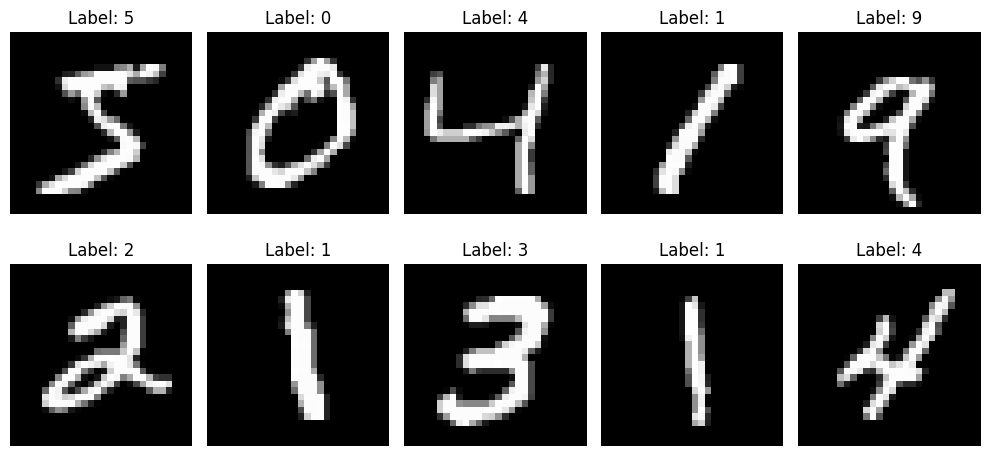

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from time import time

# PART 1: DATA PREPARATION
# ========================

# Define transformations for the training and test sets
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the data to [-1, 1]
])

# Load the MNIST dataset
# Download is True to download if not already downloaded
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Convert entire datasets to tensors
train_images = torch.empty(len(trainset), 1, 28, 28)
train_labels = torch.empty(len(trainset), dtype=torch.long)
test_images = torch.empty(len(testset), 1, 28, 28)
test_labels = torch.empty(len(testset), dtype=torch.long)

# Fill the tensors with data
for idx, (image, label) in enumerate(trainset):
    train_images[idx] = image
    train_labels[idx] = label

for idx, (image, label) in enumerate(testset):
    test_images[idx] = image
    test_labels[idx] = label

# Reshape images to flatten them for the FCNN (from [N, 1, 28, 28] to [N, 784])
train_images_flat = train_images.reshape(-1, 28*28)
test_images_flat = test_images.reshape(-1, 28*28)

# Function to display some sample images
def show_images(images, labels, num_images=10):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):  # Show images
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i].reshape(28, 28).numpy().squeeze(), cmap='gray')
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show some training images
show_images(train_images_flat, train_labels)


## Model definition

In [22]:
# PART 2: MODEL DEFINITION
# ========================

class FCNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):

        super(FCNNClassifier, self).__init__()

        # Create a list to hold all layers
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_size))
        self.layers.append(nn.ReLU())  # Activation after input layer

        # Hidden layers
        for _ in range(num_layers - 1):  # Subtract 1 to account for input layer
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(nn.ReLU())  # Activation after each hidden layer

        # Output layer
        self.layers.append(nn.Linear(hidden_size, num_classes))

    def forward(self, x):
        """Forward pass through the network."""
        # Forward through all but the last layer with ReLU activation
        for layer in self.layers[:-1]:  # All layers except the last
            x = layer(x)

        # Output layer (without activation - will be handled by loss function)
        x = self.layers[-1](x)  # Last layer is linear (no softmax yet)

        return x

## Training

The cross-entropy loss (implemented via nn.CrossEntropyLoss()) is the default loss function to use for multi-class classification problems where each class is assigned a unique integer value from 0 to (num_classes – 1). For each input sample:
- The model produces a vector of raw scores (logits) - one score per class.,
- These scores are converted to probabilities using the softmax function:
$\text{softmax}(z)_i = \frac{e^{z_i}}{\sum_j e^{z_j}}$
- Cross-entropy then calculates the "distance" between this predicted probability distribution and the true distribution:
$$\text{CE}(y, \hat{y}) = -\sum_i y_i \log(\hat{y}_i)$$

The loss decreases when the model assigns higher probability to the correct class. Perfect predictions (probability of 1.0 for the correct class) result in zero loss. This behavior encourages the model to be confident about correct predictions while heavily penalizing confident incorrect predictions.







In [24]:
# PART 3: TRAINING AND EVALUATION
# ===============================

# Hyperparameters
input_size = 28 * 28  # MNIST images are 28x28 pixels
hidden_size = 128
num_layers = 2
num_classes = 10  # 10 digits (0-9)
learning_rate = 0.005
num_epochs = 100

# Create the model, loss function, and optimizer
model = FCNNClassifier(input_size, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop - using the entire dataset at once instead of batches
train_loss_list = []
train_accs_list = []
test_loss_list = []
test_accs = []

start_time = time()

for epoch in range(num_epochs):

    # Forward pass on training data train_images_flat
    # output = ...
    output = model(train_images_flat)

    # compute loss on training data
    # loss = ...
    loss = criterion(output, train_labels)

    # Backprop and optimize
    # ...                       # Clear the gradients
    # ...                       # Perform backpropagation
    # ...                       # Update the weights
    optimizer.zero_grad()   # Clear the gradients (reset gradients to zero)
    loss.backward()         # Perform backpropagation (compute gradients)
    optimizer.step()        # Update the weights (adjust parameters based on gradients)

    # Calculate training accuracy
    _, predicted = torch.max(output.data, 1)
    train_accuracy = 100 * (predicted == train_labels).sum().item() / len(train_labels)

    # Save training metrics
    train_loss_list.append(loss.item())
    train_accs_list.append(train_accuracy)

    # Evaluation phase
    test_outputs = model(test_images_flat)
    test_loss = criterion(test_outputs, test_labels).item()

    # Calculate test accuracy
    _, test_predicted = torch.max(test_outputs.data, 1)
    test_accuracy = 100 * (test_predicted == test_labels).sum().item() / len(test_labels)

    # Save test metrics
    test_loss_list.append(test_loss)
    test_accs.append(test_accuracy)

    # Print epoch statistics
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

elapsed_time = time() - start_time
print(f'Training completed in {elapsed_time:.2f} seconds')


Epoch [10/100], Train Loss: 0.8442, Train Accuracy: 77.58%, Test Loss: 0.7947, Test Accuracy: 77.66%
Epoch [20/100], Train Loss: 0.4682, Train Accuracy: 86.27%, Test Loss: 0.4430, Test Accuracy: 87.54%
Epoch [30/100], Train Loss: 0.3773, Train Accuracy: 89.04%, Test Loss: 0.3520, Test Accuracy: 89.77%
Epoch [40/100], Train Loss: 0.3196, Train Accuracy: 90.67%, Test Loss: 0.3061, Test Accuracy: 91.24%
Epoch [50/100], Train Loss: 0.2852, Train Accuracy: 91.64%, Test Loss: 0.2747, Test Accuracy: 91.89%
Epoch [60/100], Train Loss: 0.2593, Train Accuracy: 92.34%, Test Loss: 0.2515, Test Accuracy: 92.48%
Epoch [70/100], Train Loss: 0.2363, Train Accuracy: 93.05%, Test Loss: 0.2317, Test Accuracy: 93.17%
Epoch [80/100], Train Loss: 0.2151, Train Accuracy: 93.66%, Test Loss: 0.2147, Test Accuracy: 93.76%
Epoch [90/100], Train Loss: 0.1954, Train Accuracy: 94.25%, Test Loss: 0.1983, Test Accuracy: 94.19%
Epoch [100/100], Train Loss: 0.1790, Train Accuracy: 94.78%, Test Loss: 0.1848, Test Accura

## Visualization


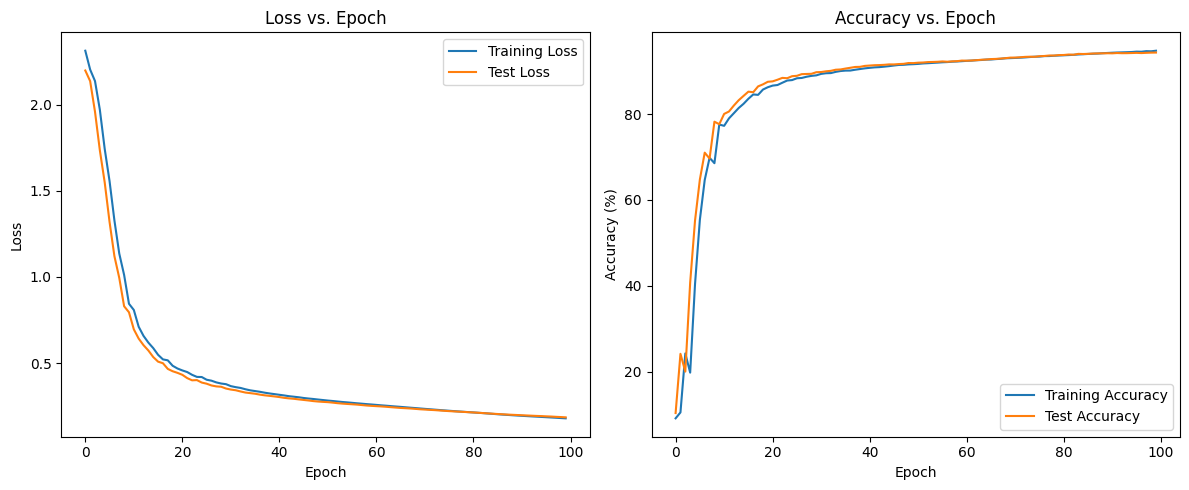

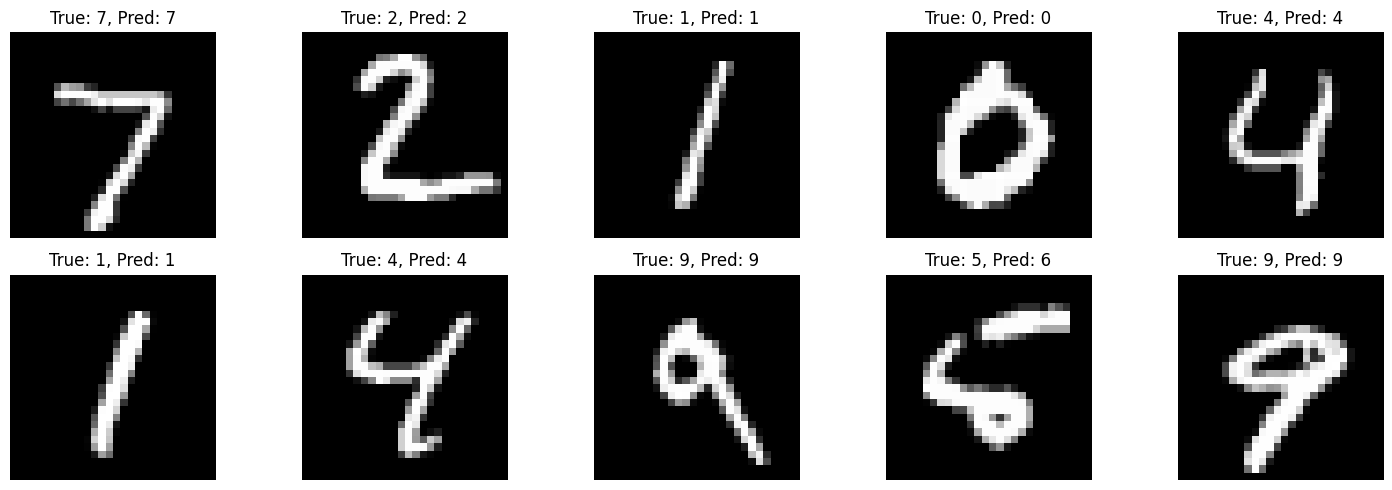

In [25]:
# PART 4: VISUALIZATION AND ANALYSIS
# ==================================

# Plot the training and test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Training Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

# Plot the training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs_list, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# Visualize some predictions
def display_predictions(model, images, true_labels, num_images=10):
    """Display some test images along with their predicted labels."""
    # Get predictions
    with torch.no_grad():
        outputs = model(images[:num_images])
        _, predicted = torch.max(outputs, 1)

    # Display images and their predictions
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i].reshape(28, 28).numpy().squeeze(), cmap='gray')
        plt.title(f'True: {true_labels[i].item()}, Pred: {predicted[i].item()}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_predictions(model, test_images_flat, test_labels)

# Contacts
In case you have some doubts on the exercises, or any additional quesiton, please contact me at the following e-mail:

emanuele.bombardi@ulb.be